In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 12128, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 12128 (delta 1), reused 2 (delta 0), pack-reused 12122
Receiving objects: 100% (12128/12128), 11.93 MiB | 9.59 MiB/s, done.
Resolving deltas: 100% (8395/8395), done.


In [ ]:
# clone project repository
!git clone https://github.com/alexzhao428/2022-432-Project.git

Cloning into '2022-432-Project'...
remote: Enumerating objects: 17504, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17504 (delta 3), reused 16 (delta 2), pack-reused 17479
Receiving objects: 100% (17504/17504), 745.34 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (3826/3826), done.
Checking out files: 100% (17607/17607), done.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# install dependencies as necessary
%cd yolov5/
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
input_data = '../Raw Data'
annotations_path = "../Raw Data/annotations"
images_path = ".../Raw Data/images"

In [ ]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [ ]:
df=pd.DataFrame(dataset)
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss0,without_mask,512,366,79,105,109,142,2
1,maksssksksss0,with_mask,512,366,185,100,226,144,0
2,maksssksksss0,without_mask,512,366,325,90,360,141,2
3,maksssksksss1,with_mask,400,156,321,34,354,69,0
4,maksssksksss1,with_mask,400,156,224,38,261,73,0


In [ ]:
fileNames = [*os.listdir("../Raw Data/images")]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 853 images in the dataset


In [ ]:
# train, validation, and test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [ ]:
# create separate train test and validation directory inside yolo/data/
%cd ..
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

/content/drive/MyDrive/Colab Notebooks


In [ ]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open("Raw Data/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save("yolov5/data/"+folder_Name+"/images/"+image)

# copyImages to train/val/test folders
copyImages(train, "train")
print("train")
copyImages(val, "val")
print("val")
copyImages(test, "test")
print("test")

train
val
test


In [ ]:
# reformat the dataframe columns
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

df.astype('string')
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss0,without_mask,512,366,98,137,136,186,2,0.182812,0.336458,0.059375,0.102083
1,maksssksksss0,with_mask,512,366,231,131,282,188,0,0.400781,0.332292,0.079687,0.118750
2,maksssksksss0,without_mask,512,366,406,118,450,184,2,0.668750,0.314583,0.068750,0.137500
3,maksssksksss1,with_mask,400,156,513,104,566,212,0,0.842969,0.329167,0.082812,0.225000
4,maksssksksss1,with_mask,400,156,358,116,417,224,0,0.605469,0.354167,0.092188,0.225000


In [ ]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(str(row['class'])+" "+str(row["x_center"])+" "+str(row["y_center"])+" "+str(row["box_height"])+" "+str(row["box_width"]))
            text = "\n".join(box_list)
           
            with open("yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
                file.write(text)

# create labels for train/val/test
create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [ ]:
%cd yolov5
# to display images
from IPython.display import Image, clear_output
import torch

/content/drive/MyDrive/Colab Notebooks/yolov5


In [ ]:
# configure the first yaml file with train, validation, and test path, number of classes, and class names
yaml_text = """
train: data/train/images
val: data/val/images
test: data/test/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml


train: data/train/images
val: data/val/images
test: data/test/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

## YOLOv5n

In [ ]:
# configure the second yaml file with model architecture for yolov5n
%%writetemplate models/custom_yolov5n.yaml

# Parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [ ]:
# train the model and evaluate on validation set
!python train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5n.yaml --weights yolov5n.pt --name yolov5n_results  --cache

train: weights=yolov5n.pt, cfg=models/custom_yolov5n.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5n_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05

## YOLOv5s

In [ ]:
# configure the second yaml file with model architecture for yolov5s
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [ ]:
!python train.py --img 640 --batch 32 --epochs 20 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results_20epochs  --cache

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results_20epochs, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,

In [22]:
!python train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results_50epochs  --cache

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results_50epochs, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,

## YOLOv5m

In [23]:
# configure the second yaml file with model architecture for yolov5m
%%writetemplate models/custom_yolov5m.yaml

# Parameters
nc: 3  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [24]:
!python train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5m.yaml --weights yolov5m.pt --name yolov5m_results  --cache

train: weights=yolov5m.pt, cfg=models/custom_yolov5m.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5m_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05

## YOLOv5l

In [25]:
# configure the second yaml file with model architecture for yolov5l
%%writetemplate models/custom_yolov5l.yaml

# Parameters
nc: 3  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [26]:
!python train.py --img 640 --batch 8 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5l.yaml --weights yolov5l.pt --name yolov5l_results  --cache

train: weights=yolov5l.pt, cfg=models/custom_yolov5l.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5l_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05,

In [27]:
!python detect.py --source data/test/images --weight runs/train/yolov5n_results/weights/best.pt --name yolov5n_results  --save-txt

detect: weights=['runs/train/yolov5n_results/weights/best.pt'], source=data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5n_results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5n summary: 213 layers, 1763224 parameters, 0 gradients, 4.2 GFLOPs
image 1/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss1.png: 480x640 7 with_masks, 1 without_mask, Done. (0.011s)
image 2/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss102.png: 480x6

In [40]:
!python detect.py --source data/test/images --weight runs/train/yolov5s_results_50epochs//weights/best.pt --name yolov5s_results  --save-txt

detect: weights=['runs/train/yolov5s_results_50epochs//weights/best.pt'], source=data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5s_results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
image 1/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss1.png: 480x640 6 with_masks, 1 without_mask, Done. (0.011s)
image 2/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss102

In [29]:
!python detect.py --source data/test/images --weight runs/train/yolov5m_results/weights/best.pt --name yolov5m_results  --save-txt

detect: weights=['runs/train/yolov5m_results/weights/best.pt'], source=data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5m_results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5m summary: 290 layers, 20861016 parameters, 0 gradients, 48.0 GFLOPs
image 1/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss1.png: 480x640 7 with_masks, 1 without_mask, Done. (0.014s)
image 2/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss102.png: 480

In [30]:
!python detect.py --source data/test/images --weight runs/train/yolov5l_results/weights/best.pt --name yolov5l_results  --save-txt

detect: weights=['runs/train/yolov5l_results/weights/best.pt'], source=data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5l_results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-5-30 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5l summary: 367 layers, 46119048 parameters, 0 gradients, 107.8 GFLOPs
image 1/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss1.png: 480x640 7 with_masks, 1 without_mask, Done. (0.023s)
image 2/25 /content/drive/MyDrive/Colab Notebooks/yolov5/data/test/images/maksssksksss102.png: 48

In [35]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [36]:
def show_image(img_id, folder):
    df_image = df[df.file==img_id]
    print(df_image)
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id+'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        print((row['xmin'], row['ymin']))
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=5)

    img_pred = plt.imread('runs/detect/'+folder+'/'+img_id+'.png')
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                file                   name  width  height  xmin  ymin  xmax  \
176  maksssksksss130  mask_weared_incorrect    332     400    13   124    88   
177  maksssksksss130  mask_weared_incorrect    332     400   312    69   400   
178  maksssksksss130           without_mask    332     400   586   114   640   
179  maksssksksss130           without_mask    332     400   381   114   429   

     ymax  class  x_center  y_center  box_height  box_width  
176   176      1  0.078906  0.312500    0.117188   0.108333  
177   134      1  0.556250  0.211458    0.137500   0.135417  
178   169      2  0.957812  0.294792    0.084375   0.114583  
179   163      2  0.632812  0.288542    0.075000   0.102083  
(13, 124)
(312, 69)
(586, 114)
(381, 114)


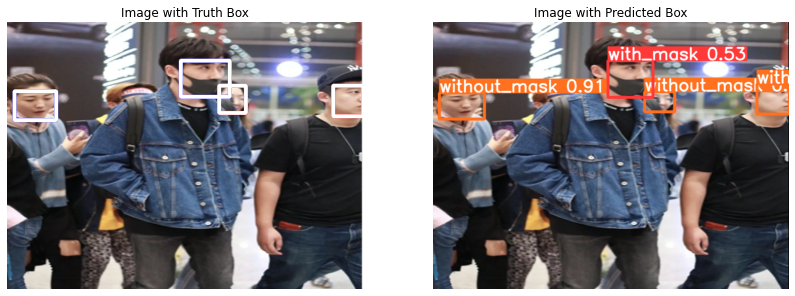

In [38]:
show_image("maksssksksss130", "yolov5n_results")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                file                   name  width  height  xmin  ymin  xmax  \
176  maksssksksss130  mask_weared_incorrect    332     400    13   124    88   
177  maksssksksss130  mask_weared_incorrect    332     400   312    69   400   
178  maksssksksss130           without_mask    332     400   586   114   640   
179  maksssksksss130           without_mask    332     400   381   114   429   

     ymax  class  x_center  y_center  box_height  box_width  
176   176      1  0.078906  0.312500    0.117188   0.108333  
177   134      1  0.556250  0.211458    0.137500   0.135417  
178   169      2  0.957812  0.294792    0.084375   0.114583  
179   163      2  0.632812  0.288542    0.075000   0.102083  
(13, 124)
(312, 69)
(586, 114)
(381, 114)


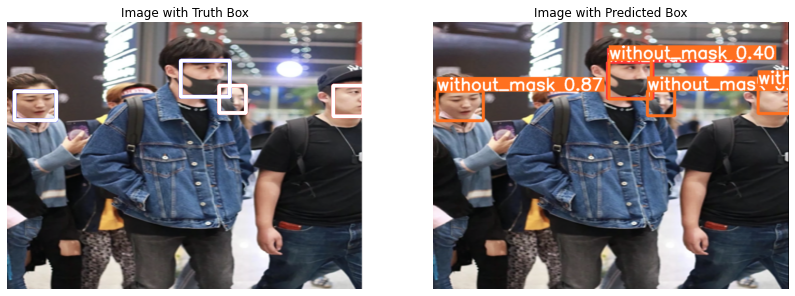

In [42]:
show_image("maksssksksss130", "yolov5s_results")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                file                   name  width  height  xmin  ymin  xmax  \
176  maksssksksss130  mask_weared_incorrect    332     400    13   124    88   
177  maksssksksss130  mask_weared_incorrect    332     400   312    69   400   
178  maksssksksss130           without_mask    332     400   586   114   640   
179  maksssksksss130           without_mask    332     400   381   114   429   

     ymax  class  x_center  y_center  box_height  box_width  
176   176      1  0.078906  0.312500    0.117188   0.108333  
177   134      1  0.556250  0.211458    0.137500   0.135417  
178   169      2  0.957812  0.294792    0.084375   0.114583  
179   163      2  0.632812  0.288542    0.075000   0.102083  
(13, 124)
(312, 69)
(586, 114)
(381, 114)


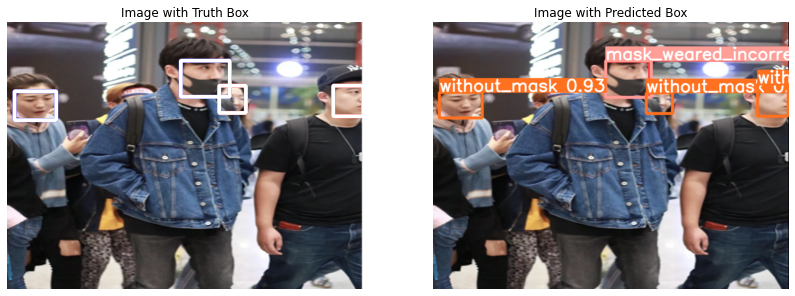

In [43]:
show_image("maksssksksss130", "yolov5m_results")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                file                   name  width  height  xmin  ymin  xmax  \
176  maksssksksss130  mask_weared_incorrect    332     400    13   124    88   
177  maksssksksss130  mask_weared_incorrect    332     400   312    69   400   
178  maksssksksss130           without_mask    332     400   586   114   640   
179  maksssksksss130           without_mask    332     400   381   114   429   

     ymax  class  x_center  y_center  box_height  box_width  
176   176      1  0.078906  0.312500    0.117188   0.108333  
177   134      1  0.556250  0.211458    0.137500   0.135417  
178   169      2  0.957812  0.294792    0.084375   0.114583  
179   163      2  0.632812  0.288542    0.075000   0.102083  
(13, 124)
(312, 69)
(586, 114)
(381, 114)


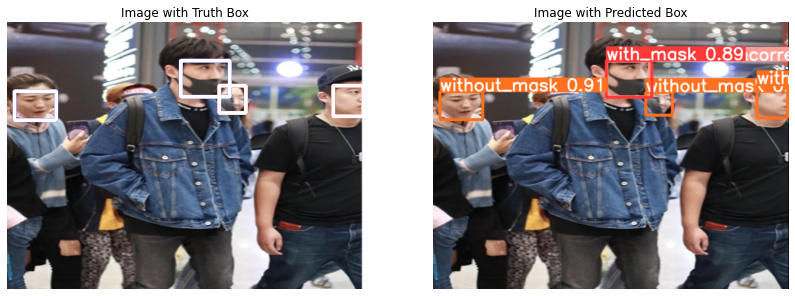

In [44]:
show_image("maksssksksss130", "yolov5l_results")